In [175]:
import glob
import scipy.ndimage
import sklearn.linear_model
import scipy.ndimage.filters

import numpy as np
import pylab as plt

import lemur_util

from lemur_pca import lemur_PCA
from lemur_soar import LemurSOAR


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

N_IMAGES = 200
NEUTRAL_FACES_GLOB = 'faces/*a*'  # Select all the neutral faces
SMILING_FACES_GLOB = 'faces/*b*'  # Select all the smiling faces

N_TEST = 5
N_TRAINING = N_IMAGES - N_TEST

KAGGLE_FACES = 'faces.txt'
N_FEATURES = 3000


# Load neutral faces
neutral = []
for filename in sorted(glob.glob(NEUTRAL_FACES_GLOB)):
  neutral.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
neutral = np.array(neutral)

# Load smiling faces
smiling = []
for filename in sorted(glob.glob(SMILING_FACES_GLOB)):
  smiling.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
smiling = np.array(smiling)

V = lemur_PCA(KAGGLE_FACES, N_FEATURES, 2)

In [195]:
from lemur_soar import LemurSOAR

N_TEST = 5
N_TRAINING = N_IMAGES - N_TEST

# Shuffle images
p = np.random.permutation(smiling.shape[0])

neutral = neutral[p]
smiling = smiling[p]

neutral_pca = neutral.dot(V)
smiling_pca = smiling.dot(V)

neutral_training = neutral[:N_TRAINING]
smiling_training = smiling[:N_TRAINING]

neutral_training_pca = neutral_pca[:N_TRAINING]
smiling_training_pca = smiling_pca[:N_TRAINING]

neutral_test = neutral[N_TRAINING:]
smiling_test = smiling[N_TRAINING:]

neutral_test_pca = neutral_pca[N_TRAINING:]
smiling_test_pca = smiling_pca[N_TRAINING:]

neutral_training = np.append(neutral_training, smiling[:N_TRAINING], axis=0)
smiling_training = np.append(smiling_training, smiling[:N_TRAINING], axis=0)

neutral_training_pca = np.append(neutral_training_pca, smiling_pca[:N_TRAINING], axis=0)
smiling_training_pca = np.append(smiling_training_pca, smiling_pca[:N_TRAINING], axis=0)

In [196]:
gaussian_kernel = np.zeros((5, 5))
gaussian_kernel[2,2] = 1
gaussian_kernel = scipy.ndimage.filters.gaussian_filter(gaussian_kernel, .4)

span = 2

M = np.zeros((9216, 9216))
for i in xrange(9216):
  K = np.zeros((96, 96))
  r = i / 96
  c = i % 96
  
  r_fr = max(0, r - span)
  r_to = min(96, r + span + 1)
  
  c_fr = max(0, c - span)
  c_to = min(96, c + span + 1)
  
  r2_fr = r_fr - r + span
  r2_to = r_to - r + span
  
  c2_fr = c_fr - c + span
  c2_to = c_to - c + span

  K[r_fr:r_to,c_fr:c_to] = gaussian_kernel[r2_fr:r2_to,c2_fr:c2_to]
  K = K.flatten()
  M[i] = K
  del K

In [146]:
R3 = sklearn.linear_model.Ridge(alpha=0.1).fit(neutral_training, smiling_training - np.dot(neutral_training, M))
W3 = R3.coef_ + M

In [197]:
R1 = sklearn.linear_model.Ridge(alpha=0.1).fit(neutral_training_pca, smiling_training_pca)
R2 = sklearn.linear_model.Ridge(alpha=0.1).fit(neutral_training_pca, smiling_training_pca - neutral_training_pca)

W1 = R1.coef_
W2 = R2.coef_ + np.eye(N_FEATURES)

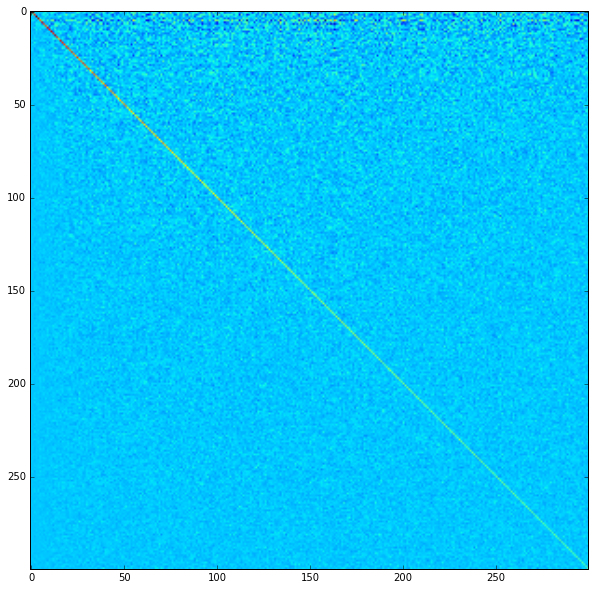

In [218]:
plt.imshow(W1[:300,:300])
plt.show()

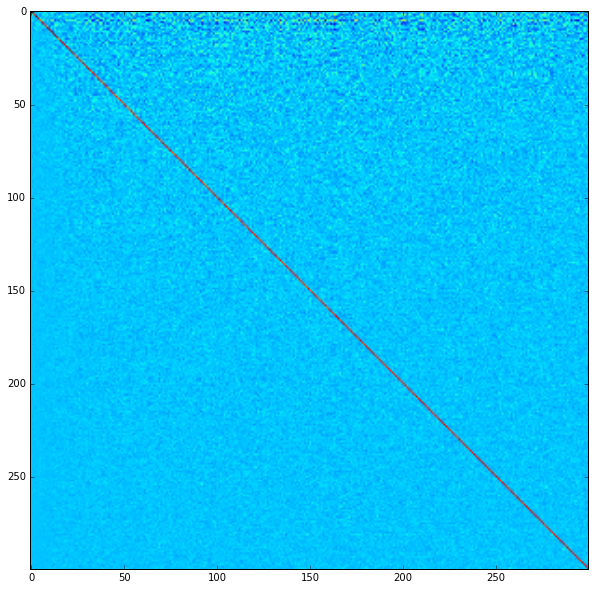

In [219]:
plt.imshow(W2[:300,:300])
plt.show()

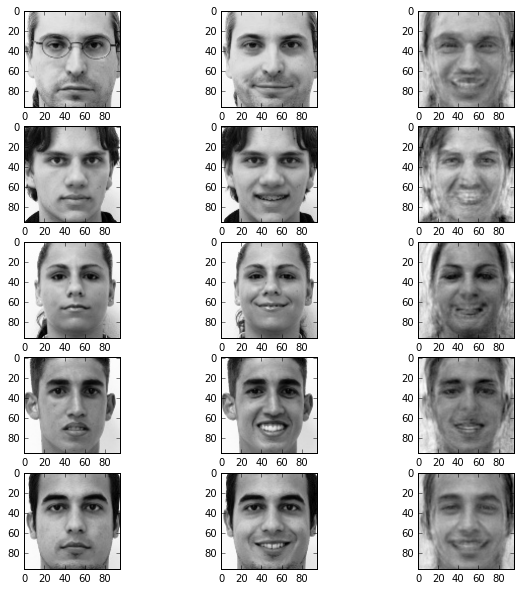

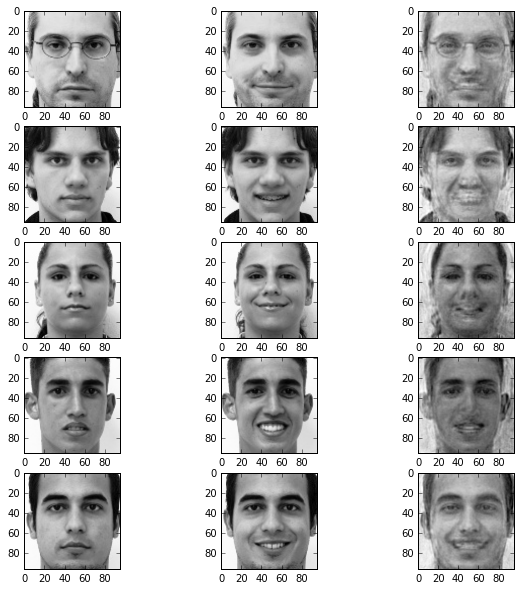

In [200]:
P1 = R1.predict(neutral_test_pca)
P2 = (R2.predict(neutral_test_pca) + neutral_test_pca)
#P3 = R3.predict(neutral_test) + np.dot(neutral_test, M)

lemur_util.plot_predictions(neutral_test, smiling_test, P1.dot(V.T))
lemur_util.plot_predictions(neutral_test, smiling_test, P2.dot(V.T))
#lemur_util.plot_predictions(neutral_test, smiling_test, P3)